Premiums (mu):
[0.08745401 0.34507143 0.12319939 0.10986585 0.26560186 0.06559945
 0.05580836 0.33661761 0.1101115  0.12080726 0.05205845 0.14699099
 0.13324426 0.07123391 0.0681825  0.06834045 0.08042422 0.10247564
 0.0931945  0.07912291]

Correlation matrix:
[[1.         0.12615321 0.46808219 0.52294653 0.14874992 0.55926161
  0.51621211 0.18820176 0.49334809 0.46884821 0.52651577 0.51109827
  0.46800588 0.58388909 0.50173138 0.5357624  0.47962296 0.4485842
  0.48023979 0.45432764]
 [0.12615321 1.         0.13057376 0.25326185 0.18951904 0.25586136
  0.15634934 0.21523739 0.16601838 0.12689944 0.25378932 0.27290614
  0.29295528 0.22328225 0.21292546 0.26364702 0.15619643 0.18392711
  0.17419645 0.22278832]
 [0.46808219 0.13057376 1.         0.46876514 0.15952905 0.48606996
  0.46381727 0.24357267 0.49992443 0.51485157 0.48659195 0.51135801
  0.41456061 0.51910444 0.52474925 0.53892045 0.49444722 0.45322975
  0.49874086 0.46211214]
 [0.52294653 0.25326185 0.46876514 1.         0.18195

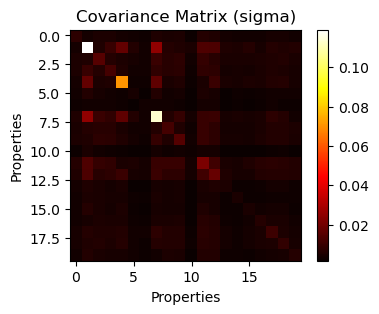

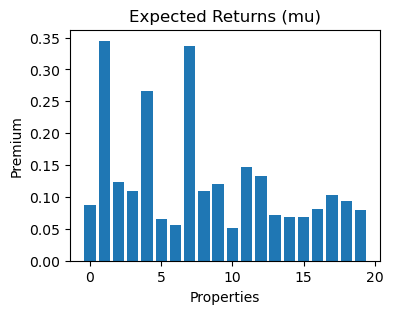

Algorithm Iterations:   1%|          | 1/100 [00:04<07:52,  4.77s/it]

Iteration 0: Best Fitness = -163.22852555876946


Algorithm Iterations:  21%|██        | 21/100 [01:26<05:21,  4.07s/it]

Iteration 20: Best Fitness = -36.176960950739726


Algorithm Iterations:  41%|████      | 41/100 [02:49<04:01,  4.09s/it]

Iteration 40: Best Fitness = -30.983576744977068


Algorithm Iterations:  61%|██████    | 61/100 [04:10<02:38,  4.06s/it]

Iteration 60: Best Fitness = -30.983576744977068


Algorithm Iterations:  81%|████████  | 81/100 [05:34<01:17,  4.10s/it]

Iteration 80: Best Fitness = -30.983576744977068


Algorithm Iterations: 100%|██████████| 100/100 [06:51<00:00,  4.12s/it]



Genetic Algorithm Result (Pennylane):
Best Portfolio Found: [1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0] with Fitness = -30.983576744977068


Exhaustive Search: 100%|██████████| 15504/15504 [00:00<00:00, 157432.24it/s]


Exhaustive Search (Classical) Result:
Optimal Portfolio (Exact Best): [0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0] with Fitness = -25.87580033812101

Fitness Comparison:
Fitness from Genetic Algorithm: -30.983576744977068
Fitness from Exhaustive Search (Exact Best): -25.87580033812101


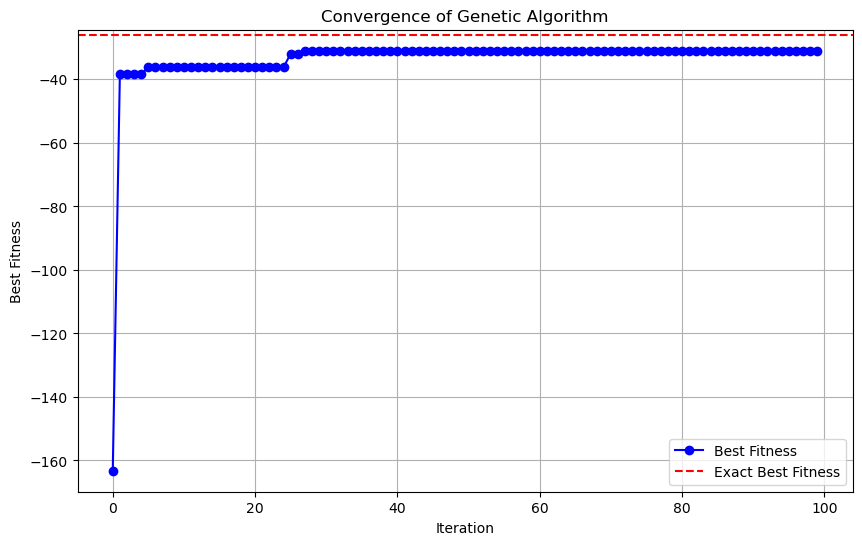

In [3]:
import pennylane as qml
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------- Data Initialization ---------------------
np.random.seed(42)
n_properties = 20
budget = 5

# Create a simulated ground truth (only used for generating meaningful mu and sigma)
X_opt = np.zeros(n_properties, dtype=int)
X_opt[[1, 4, 7]] = 1

# Generate expected returns (mu) and boost those of the selected ones
mu = np.random.uniform(0.05, 0.15, n_properties)
mu[X_opt == 1] += 0.2
print("Premiums (mu):")
print(mu)

# Build a symmetric correlation matrix randomly
base_corr = np.random.uniform(0.1, 0.3, (n_properties, n_properties))
correlation_matrix = (base_corr + base_corr.T) / 2
np.fill_diagonal(correlation_matrix, 1)
# For variety, increase correlation between non-selected properties slightly.
for i in range(n_properties):
    for j in range(n_properties):
        if X_opt[i] == 0 and X_opt[j] == 0 and i != j:
            correlation_matrix[i, j] += 0.3
print("\nCorrelation matrix:")
print(correlation_matrix)

# Display covariance matrix for reference
sigma = correlation_matrix * np.outer(mu, mu)
plt.figure(figsize=(4,3))
plt.imshow(sigma, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Covariance Matrix (sigma)")
plt.xlabel("Properties")
plt.ylabel("Properties")
plt.show()

plt.figure(figsize=(4,3))
plt.bar(range(n_properties), mu)
plt.title("Expected Returns (mu)")
plt.xlabel("Properties")
plt.ylabel("Premium")
plt.show()

# --------------------- Problem Parameters ---------------------
risk_aversion = 3.0
penalty_weight = 100  # Strong penalty to enforce exactly 'budget' selections.

# --------------------- Fitness Function ---------------------
def evaluate_fitness(bitstring, mu, corr, budget, risk_aversion, penalty_weight):
    """
    Fitness = Premium - risk_aversion * Risk - penalty * (|#selected - budget|)
    Risk is computed via the quadratic form using the correlation matrix.
    A higher fitness indicates a better portfolio.
    """
    x = np.array(bitstring)
    premium = np.dot(x, mu)
    risk = x.T @ corr @ x
    penalty = penalty_weight * abs(np.sum(x) - budget)
    return premium - risk_aversion * risk - penalty

# --------------------- Pennylane Circuit & Measurement ---------------------
dev = qml.device("default.qubit", wires=n_properties, shots=1)

@qml.qnode(dev)
def circuit(params):
    # Apply an Ry rotation on every register using the given parameters.
    for i in range(n_properties):
        qml.RY(params[i], wires=i)
    # For additional entanglement, apply a CNOT gate in a ring structure.
    for i in range(n_properties):
        qml.CNOT(wires=[i, (i+1) % n_properties])
    # Measure all registers.
    return qml.sample(wires=range(n_properties))

def measure_individual(parameters):
    return circuit(parameters)

# --------------------- Parameter Update Function ---------------------
def update_individual(individual_params, best_bitstring, measured_bitstring, delta=0.05):
    """
    Update the rotation angle for each register based on the difference between
    the measured bit and the corresponding bit in the best solution.
    
    For a register in state:
        |ψ> = cos(θ/2)|0> + sin(θ/2)|1>,
    the chance of measuring 1 is sin²(θ/2).
    To favor a 0 outcome, decrease θ; to favor a 1 outcome, increase θ.
    The updated angle is clamped to the interval [0, π].
    """
    new_params = individual_params.copy()
    for j in range(len(measured_bitstring)):
        if measured_bitstring[j] != best_bitstring[j]:
            if best_bitstring[j] == 0 and measured_bitstring[j] == 1:
                new_params[j] = max(0, individual_params[j] - delta)
            elif best_bitstring[j] == 1 and measured_bitstring[j] == 0:
                new_params[j] = min(np.pi, individual_params[j] + delta)
    return new_params

# --------------------- Genetic Algorithm using Pennylane ---------------------
def genetic_algorithm_pennylane(n_individuals, n_bits, mu, corr, budget,
                                 risk_aversion, penalty_weight, max_iters=100, delta=0.05):
    # Initialize the population: all candidates get rotation parameters set to π/2 (equal superposition).
    population = np.full((n_individuals, n_bits), np.pi/2)
    best_solution = None
    best_fitness_val = -np.inf
    fitness_history = []  # Record the best fitness over iterations

    for iteration in tqdm(range(max_iters), desc="Algorithm Iterations"):
        measured_population = []
        for i in range(n_individuals):
            bitstring = measure_individual(population[i])
            measured_population.append(bitstring)
            fitness_val = evaluate_fitness(bitstring, mu, corr, budget, risk_aversion, penalty_weight)
            if fitness_val > best_fitness_val:
                best_fitness_val = fitness_val
                best_solution = bitstring.copy()
        fitness_history.append(best_fitness_val)
        for i in range(n_individuals):
            population[i] = update_individual(population[i], best_solution, measured_population[i], delta)
        if iteration % 20 == 0:
            print(f"Iteration {iteration}: Best Fitness = {best_fitness_val}")
    return best_solution, best_fitness_val, fitness_history

n_individuals = 20
best_solution_algo, best_fitness_val, fitness_history = genetic_algorithm_pennylane(
    n_individuals, n_properties, mu, correlation_matrix, budget,
    risk_aversion, penalty_weight, max_iters=100, delta=0.05)

print("\nGenetic Algorithm Result (Pennylane):")
print("Best Portfolio Found:", best_solution_algo, "with Fitness =", best_fitness_val)

# --------------------- Exhaustive Search (over valid combinations) ---------------------
def exhaustive_search_classical(n, budget, mu, corr, risk_aversion, penalty_weight):
    best_assignment = None
    best_fitness = -np.inf
    total = sum(1 for _ in itertools.combinations(range(n), budget))
    for combo in tqdm(itertools.combinations(range(n), budget), total=total, desc="Exhaustive Search"):
        bitstring = np.zeros(n, dtype=int)
        bitstring[list(combo)] = 1
        fitness_val = evaluate_fitness(bitstring, mu, corr, budget, risk_aversion, penalty_weight)
        if fitness_val > best_fitness:
            best_fitness = fitness_val
            best_assignment = bitstring.copy()
    return best_assignment, best_fitness

best_assignment_classical, best_fitness_classical = exhaustive_search_classical(
    n_properties, budget, mu, correlation_matrix, risk_aversion, penalty_weight)

print("\nExhaustive Search (Classical) Result:")
print("Optimal Portfolio (Exact Best):", best_assignment_classical, "with Fitness =", best_fitness_classical)

print("\nFitness Comparison:")
print("Fitness from Genetic Algorithm:", best_fitness_val)
print("Fitness from Exhaustive Search (Exact Best):", best_fitness_classical)

# --------------------- Plot Performance History ---------------------
plt.figure(figsize=(10,6))
plt.plot(fitness_history, 'o-', color='blue', label='Best Fitness')
plt.axhline(y=best_fitness_classical, color='red', linestyle='--', label='Exact Best Fitness')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.title('Convergence of Genetic Algorithm')
plt.legend()
plt.grid(True)
plt.show()
